In [30]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [31]:
env = BlackjackEnv()

In [60]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    实现：
        这里使用的公式是Pi(a|s)对应的公式，Pi是更改后的策略。
        开始以为是类型错，但是numpy默认值就是float。
    """
    def policy_fn(observation):
        Pi = np.ones(nA) * epsilon / nA
        A_star = np.argmax(Q[observation])
        Pi[A_star] += (1.0 - epsilon)
        return Pi
    return policy_fn

In [64]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Nubmer of episodes to sample.
        discount_factor: Lambda discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function taht takes an observation as an argument and returns
        action probabilities
     实现：
        第一，在选择行动过程中，要根据策略的概率进行模拟，使用np的random.choice.
        第二，与predict的区别在于，predict已经限定了每个状态的action，故而V只用state就可以了(估计的是状态值函数），而这里需要state和action（行动值函数）
    出现的bug：
        在first_occurrence处漏了and
        episode, state初始化
        defaultdict：传入return的参数应该是一个元组(state, action)，而传入Q则可以是[state][action]
        初始化的两个值要放在for里面。
        while True没问题(对于这个问题)，算了，改成10000吧，虽然估计都超不过10
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)

    for index in range(1, num_episodes+1):
        if index % 50000 == 0:
            print("number of episode: %d\%d" %(index, num_episodes))
        episode = []
        state = env.reset()        
        for t in range(10000):
            probs = policy(state)
            action = np.random.choice(np.arange(len(probs)), p = probs)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            state = next_state
            if done == 1:
                break
                
        state_action_pair = set([tuple((x[0], x[1])) for x in episode])
        for state, action in state_action_pair:
            first_occurrence = (i for i, x in enumerate(episode) if x[0] == state and x[1] == action)
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[next(first_occurrence):])])
            returns_sum[(state,action)] += G
            returns_count[(state,action)] += 1.0
            Q[state][action] = returns_sum[(state,action)] / returns_count[(state,action)]
            
    return Q, policy

In [65]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

number of episode: 50000\500000
number of episode: 100000\500000
number of episode: 150000\500000
number of episode: 200000\500000
number of episode: 250000\500000
number of episode: 300000\500000
number of episode: 350000\500000
number of episode: 400000\500000
number of episode: 450000\500000
number of episode: 500000\500000


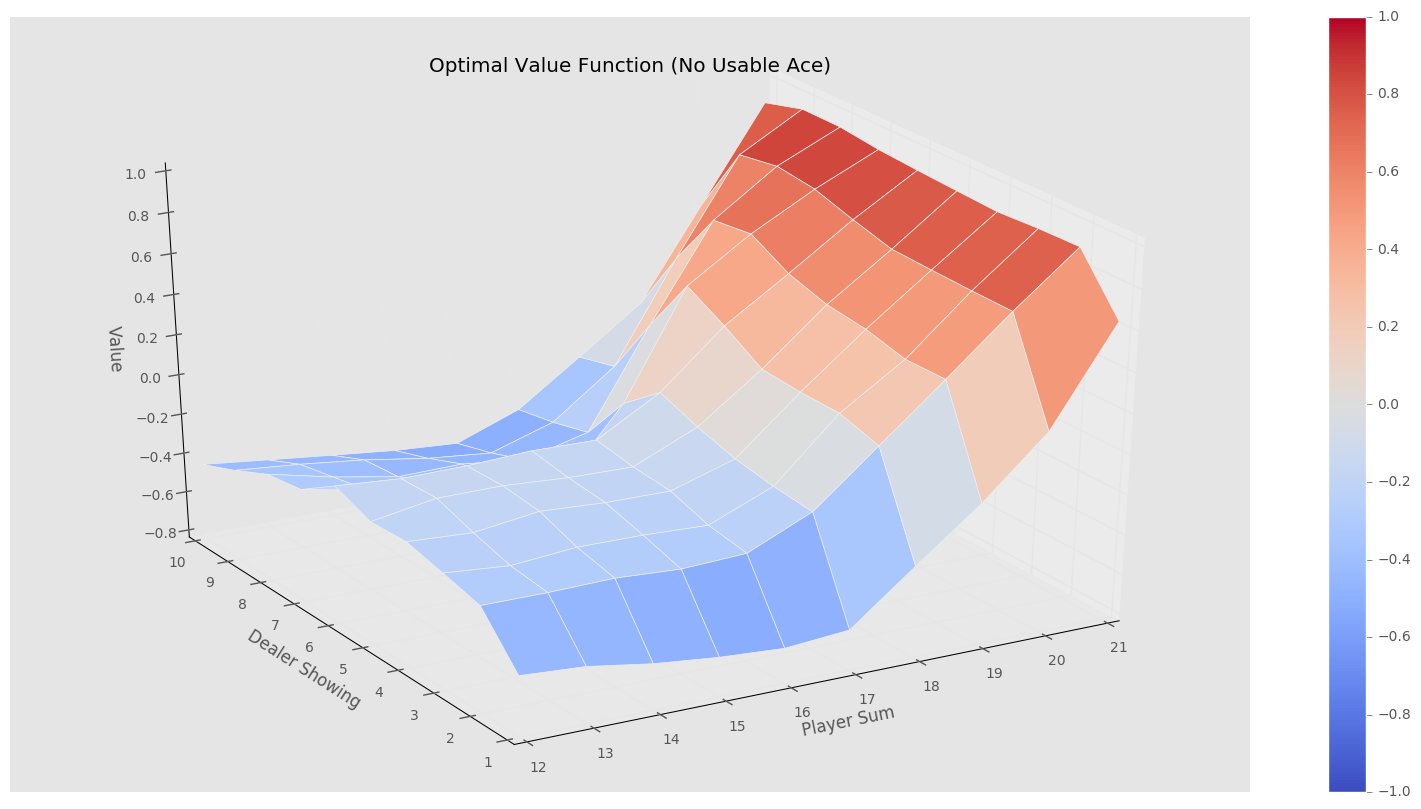

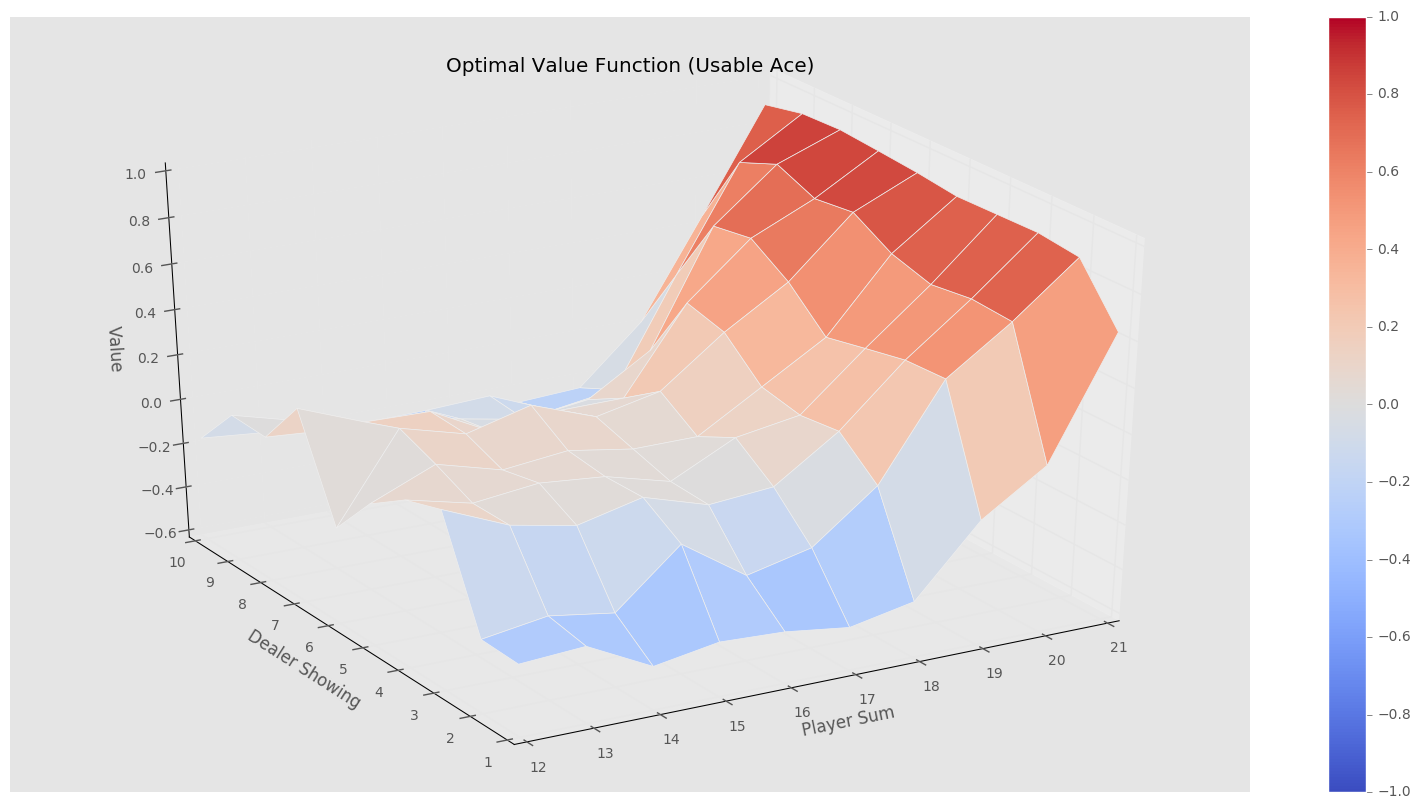

In [66]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

In [67]:
print(Q)

defaultdict(<function mc_control_epsilon_greedy.<locals>.<lambda> at 0x000001A8C6E24158>, {(18, 6, False): array([ 0.30375671, -0.76923077]), (17, 8, True): array([-0.42857143, -0.07385524]), (20, 6, False): array([ 0.71639344, -0.78571429]), (13, 1, False): array([-0.83539095, -0.55066079]), (12, 10, True): array([-0.67346939, -0.16898148]), (21, 3, True): array([ 0.88801956,  0.23636364]), (12, 5, True): array([-0.12195122,  0.        ]), (14, 2, True): array([-0.3015873 , -0.47619048]), (14, 1, True): array([-0.76146789, -0.4375    ]), (16, 4, True): array([-0.25984252, -0.02356902]), (16, 7, True): array([-0.66666667,  0.01906412]), (20, 1, True): array([ 0.11167513, -0.20734908]), (14, 6, True): array([-0.16853933,  0.10891089]), (13, 7, False): array([-0.45343511, -0.32866208]), (12, 6, False): array([-0.14142215, -0.15592516]), (19, 10, False): array([-0.01885419, -0.76588235]), (21, 6, True): array([ 0.9043729,  0.34     ]), (17, 5, False): array([-0.04319955, -0.57264957]), (1